In [23]:
import os
import cv2 as cv
import skimage as ski
import numpy as np
import pandas as pd
import seaborn as sns
from json import load

In [24]:
sourceImgDir = 'models/bicycle/images'
benchmarkDir = 'benchmarks/bicycle/Clipped'
benchmarkImgDir = benchmarkDir + '/images'

numImages = min(len(os.listdir(sourceImgDir)), len(os.listdir(benchmarkImgDir)))

In [25]:
if (os.path.exists(benchmarkDir + '/data.pkl')):
	data = pd.read_pickle(benchmarkDir + '/data.pkl')
else:
	ssim = {}
	psnr = {}
	for i, (sourcePath, benchmarkPath) in enumerate(zip(os.listdir(sourceImgDir), os.listdir(benchmarkImgDir))):
		source = cv.imread(sourceImgDir + '/' + sourcePath)
		source = cv.cvtColor(source, cv.COLOR_BGR2RGB)

		benchmark = cv.imread(benchmarkImgDir + '/' + benchmarkPath)
		benchmark = cv.cvtColor(benchmark, cv.COLOR_BGR2RGB)
		source = cv.resize(source, benchmark.shape[:2][::-1], interpolation=cv.INTER_LINEAR)

		fileName = sourcePath[:sourcePath.rfind('.')]
		ssim[fileName] = ski.metrics.structural_similarity(source, benchmark, win_size=9, channel_axis=2)
		psnr[fileName] = ski.metrics.peak_signal_noise_ratio(source, benchmark)

	timings = {}
	with open(benchmarkDir + '/timings.json') as f:
		timings = load(f)

	timings = {k:np.median(v) for k,v in timings.items()}

	dfs = [pd.DataFrame([[k, v] for k,v in dict.items()]) for dict in (psnr, ssim, timings)]
	data = pd.merge(dfs[0], dfs[1], on=0).merge(dfs[2], on=0).reset_index(drop=True).rename(columns={0: 'Image', '1_x': 'PSNR', '1_y': 'SSIM', 1: 'median frametime'})
	pd.to_pickle(data, benchmarkDir + '/data.pkl')

In [26]:
data

,Image,PSNR,SSIM,median frametime
0,_DSC8679,15.403469,0.261451,21.0000
1,_DSC8680,14.433422,0.412543,18.4775
2,_DSC8681,14.849746,0.315278,20.9925
3,_DSC8682,14.489346,0.461871,13.5175
4,_DSC8683,14.930721,0.313898,21.2425
...,...,...,...,...
189,_DSC8869,16.614524,0.267495,15.9825
190,_DSC8870,16.228081,0.241064,15.7400
191,_DSC8871,16.453296,0.254001,16.5025
192,_DSC8872,17.257230,0.290773,19.5075


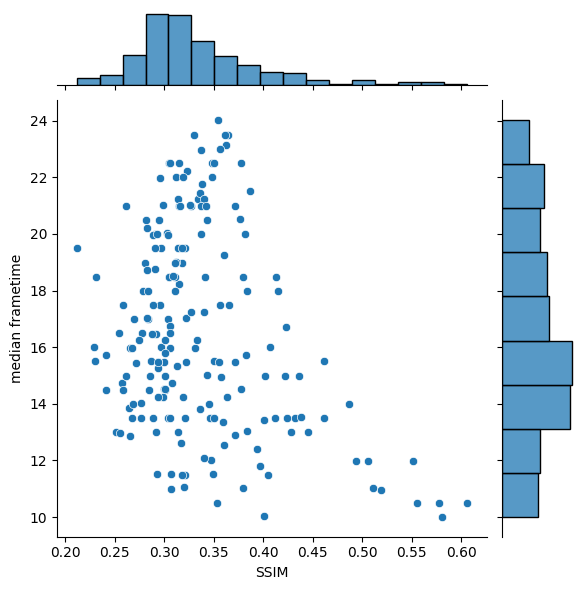

In [28]:
sns.jointplot(data, x='SSIM', y='median frametime')